<a href="https://www.kaggle.com/code/gustawohler/wine-quality-ml?scriptVersionId=93878383" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Predicting red wine quality with machine learning models

In this notebook I try to get maximum accuracy for given dataset for quality of red wine. I firstly do this for target ratings grouped into two categories:
* Bad - below and equal 5
* Good - over 5
To do this I build various models and tune hyperparameters for all of them to compare their performance and choose the best one. Used models are following:
1. Decision trees
2. Random forest
3. AdaBoost
4. Gradient boosting machines
5. Simple dense neural network
6. Gaussian naive bayes
7. Support vector classifier
After whole process I also check accuracy of models on dataset without grouped target. I treat this task as classification problem aswell because there are only 6 distinct grades in this dataset.

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
# I've already looked through every warning so this is just for clarity of returned messages
warnings.filterwarnings('ignore')

wine_attr = pd.read_csv('/kaggle/input/red-wine-quality-cortez-et-al-2009/winequality-red.csv', delimiter=',')
wine_attr.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [2]:
print('Number of attributes (with quality): ' + str(len(wine_attr.columns)))
print('\nChecking if attributes has any NaN values:')
print(pd.isna(wine_attr).any())

Number of attributes (with quality): 12

Checking if attributes has any NaN values:
fixed acidity           False
volatile acidity        False
citric acid             False
residual sugar          False
chlorides               False
free sulfur dioxide     False
total sulfur dioxide    False
density                 False
pH                      False
sulphates               False
alcohol                 False
quality                 False
dtype: bool


# Exploratory data analysis

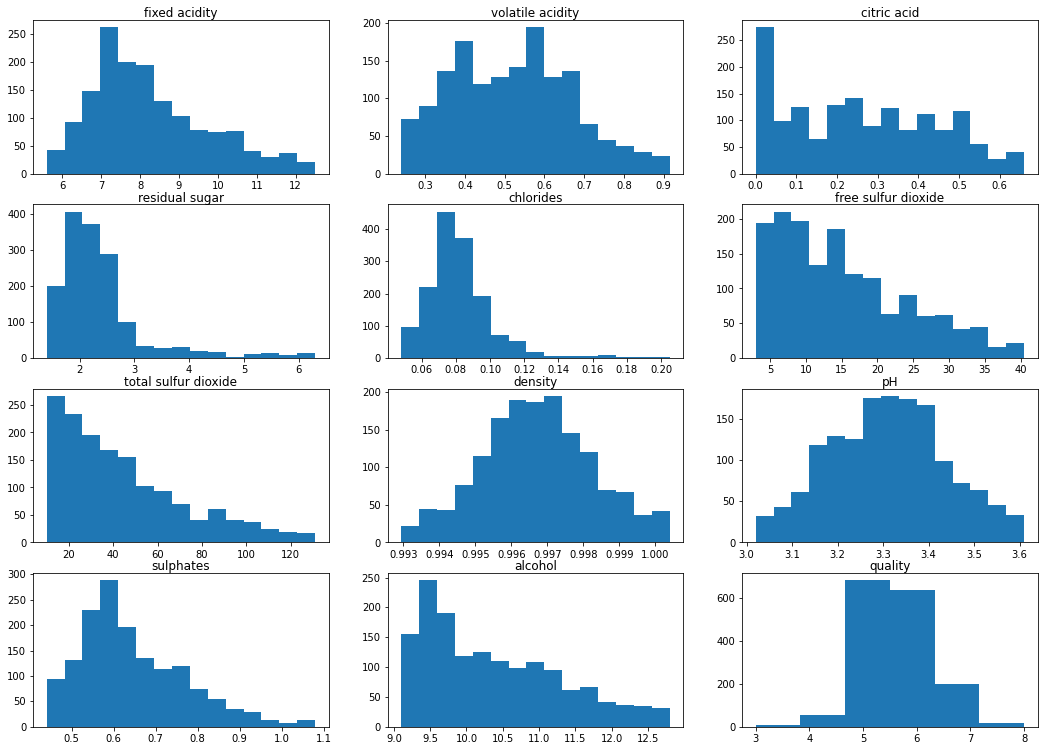

In [3]:
columns_len = 3
rows_len = 4
fig, ax = plt.subplots(rows_len, columns_len, figsize=(18,13))

col_index = 0
for i in range(rows_len):
    for j in range(columns_len):
        wanted_column = wine_attr.columns[col_index]
        wanted_series = wine_attr[wanted_column]
        if wanted_column != 'quality':
            wanted_series_wo_outliners = wanted_series[wanted_series.between(wanted_series.quantile(.025), wanted_series.quantile(.975))]
            ax[i,j].hist(wanted_series_wo_outliners, bins=15)
        else:
            ax[i,j].hist(wanted_series, bins=wanted_series.nunique())
        ax[i,j].set_title(wanted_column, pad=1)
        col_index += 1

As you can see in above histograms distribution of values for most of attributes in this dataset **is not gaussian**

<AxesSubplot:>

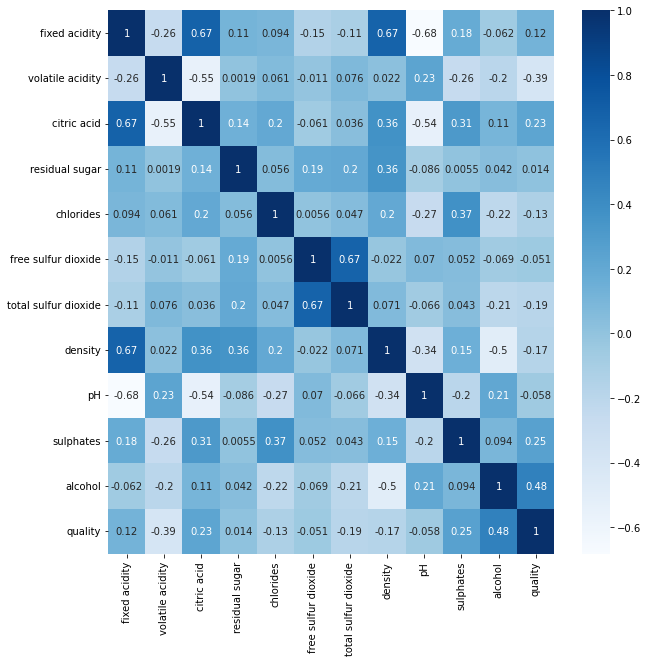

In [4]:
wine_corr = wine_attr.corr()
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(wine_corr, xticklabels=wine_corr.columns, yticklabels=wine_corr.columns, annot=True, ax=ax, cmap='Blues')

There are no strong correlations between attributes. There are some close to 0.7 or -0.7 though

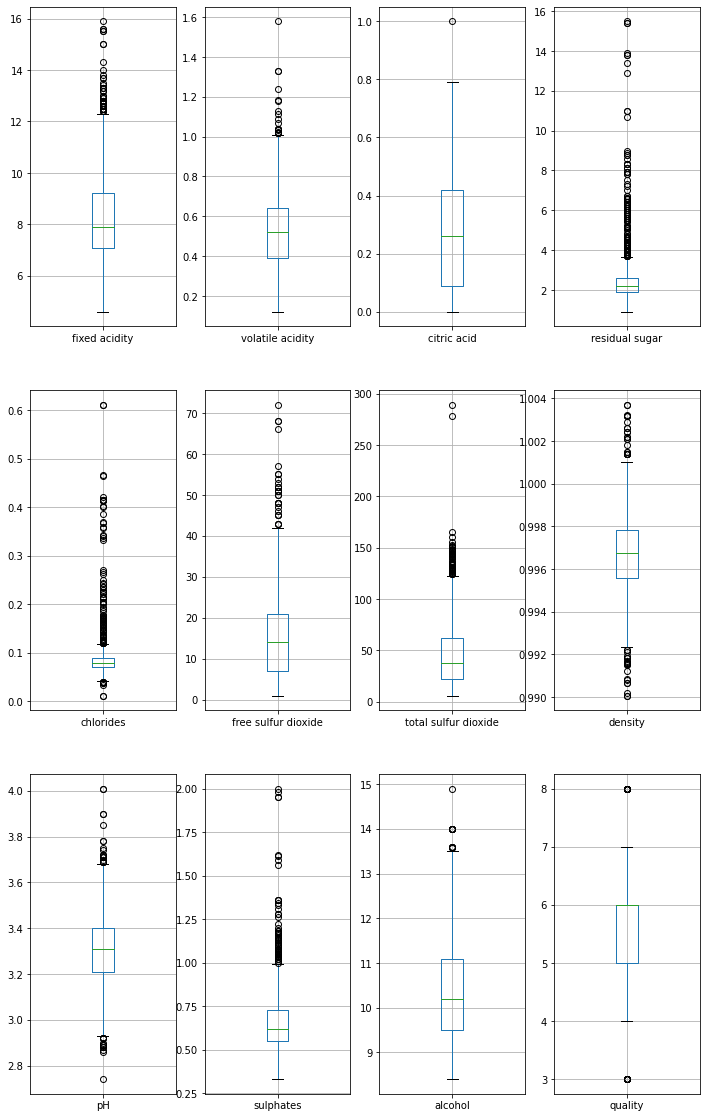

In [5]:
columns_len = 4
rows_len = 3
fig, ax = plt.subplots(rows_len, columns_len, figsize=(12,20))

col_index = 0
for i in range(rows_len):
    for j in range(columns_len):
        wine_attr.boxplot(column=wine_attr.columns[col_index], ax=ax[i,j])
        col_index += 1

We can see some outliners in every attribute - they are strongly visible in residual sugar, chlorides and sulphates. Thus we can't use MinMaxScaling for algorithms which needs preprocessed data.

As mentioned in preamble - choosed to simplify quality over 5 as "*Good*" and equal or below as "*Bad*" despite recommendation to classify 6 or lower as "*Bad*" because it had too much of class imbalance

In [6]:
wine_attr['quality_simpl'] = wine_attr['quality'].map(lambda x: 'Good' if x>5 else 'Bad')
wine_simpl = wine_attr.drop('quality', axis=1)
wine_simpl.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality_simpl
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Bad
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,Bad
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,Bad
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,Good
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,Bad


(array([744.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 855.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

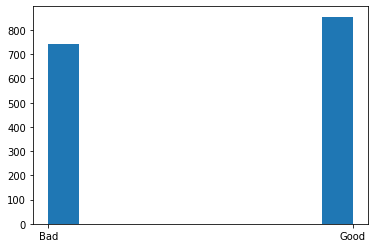

In [7]:
plt.hist(wine_simpl['quality_simpl'])

As you can see above - now classes are almost balanced - 744 to 855

In [8]:
x = wine_simpl.drop('quality_simpl', axis=1)
y = wine_simpl['quality_simpl']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y)

# Model building with default settings and evaluation on single train/test split

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)
print(classification_report(y_test, dtc.predict(x_test)))

              precision    recall  f1-score   support

         Bad       0.70      0.72      0.71       149
        Good       0.75      0.73      0.74       171

    accuracy                           0.73       320
   macro avg       0.72      0.72      0.72       320
weighted avg       0.73      0.72      0.73       320



In [10]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
print(classification_report(y_test, rfc.predict(x_test)))

              precision    recall  f1-score   support

         Bad       0.79      0.83      0.81       149
        Good       0.85      0.81      0.83       171

    accuracy                           0.82       320
   macro avg       0.82      0.82      0.82       320
weighted avg       0.82      0.82      0.82       320



In [11]:
from sklearn.ensemble import AdaBoostClassifier
abc = AdaBoostClassifier()
abc.fit(x_train, y_train)
print(classification_report(y_test, abc.predict(x_test)))

              precision    recall  f1-score   support

         Bad       0.76      0.72      0.74       149
        Good       0.77      0.80      0.79       171

    accuracy                           0.77       320
   macro avg       0.77      0.76      0.76       320
weighted avg       0.77      0.77      0.77       320



In [12]:
from sklearn.ensemble import GradientBoostingClassifier
gbc = GradientBoostingClassifier()
gbc.fit(x_train, y_train)
print(classification_report(y_test, gbc.predict(x_test)))

              precision    recall  f1-score   support

         Bad       0.77      0.78      0.78       149
        Good       0.81      0.80      0.80       171

    accuracy                           0.79       320
   macro avg       0.79      0.79      0.79       320
weighted avg       0.79      0.79      0.79       320



In [13]:
y_binary = y.astype('category')
y_binary = y_binary.cat.rename_categories([0, 1])
y_train_binary, y_test_binary = y_binary[y_train.index], y_binary[y_test.index]

In [14]:
#scaling data for NN and SVM - RobustScaler was used because data contains outliners
from sklearn.preprocessing import RobustScaler

def get_scaled_attr(x_train, x_test):
    scaler = RobustScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    return x_train_scaled, x_test_scaled

x_train_scaled, x_test_scaled = get_scaled_attr(x_train, x_test)

In [15]:
from tensorflow import keras
import tensorflow as tf
import time
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def get_default_nn_model():
    inputs = tf.keras.Input(shape=(len(x_train.columns),))
    hidden = tf.keras.layers.Dense(8, activation='relu', kernel_initializer = tf.keras.initializers.HeNormal())(inputs)
    outputs = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
    model = tf.keras.Model(inputs=inputs, outputs = outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0003), loss='binary_crossentropy', metrics=['accuracy'])
    return model

basic_nn_model = get_default_nn_model()
basic_nn_model.fit(x_train_scaled, y_train_binary, batch_size=16, epochs=100, verbose=0, shuffle=True, validation_split=0.15,
                                   callbacks=[EarlyStopping(patience=10, monitor='val_loss', mode='min'),
                                              ModelCheckpoint('./tmp/default_model_checkpoint', save_best_only=True, save_weights_only=True,
                                                                 monitor='val_accuracy', mode='max')])

basic_nn_model.load_weights('./tmp/default_model_checkpoint')

test_results = np.rint(basic_nn_model.predict(x_test_scaled))
print(classification_report(y_test_binary, test_results, target_names=['Bad', 'Good']))

2022-04-24 13:27:25.873832: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-24 13:27:26.034056: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


              precision    recall  f1-score   support

         Bad       0.71      0.73      0.72       149
        Good       0.76      0.74      0.75       171

    accuracy                           0.74       320
   macro avg       0.74      0.74      0.74       320
weighted avg       0.74      0.74      0.74       320



In [16]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train, y_train)
print(classification_report(y_test, gnb.predict(x_test)))

              precision    recall  f1-score   support

         Bad       0.77      0.68      0.72       149
        Good       0.74      0.82      0.78       171

    accuracy                           0.75       320
   macro avg       0.75      0.75      0.75       320
weighted avg       0.75      0.75      0.75       320



In [17]:
from sklearn.svm import SVC
svc = SVC()
svc.fit(x_train_scaled, y_train)
print(classification_report(y_test, svc.predict(x_test_scaled)))

              precision    recall  f1-score   support

         Bad       0.73      0.77      0.75       149
        Good       0.79      0.75      0.77       171

    accuracy                           0.76       320
   macro avg       0.76      0.76      0.76       320
weighted avg       0.76      0.76      0.76       320



In [18]:
from sklearn.metrics import accuracy_score

acc_dicts = {}
acc_dicts['decision_tree'] = accuracy_score(y_test, dtc.predict(x_test))
acc_dicts['random_forest'] = accuracy_score(y_test, rfc.predict(x_test))
acc_dicts['ada_boost'] = accuracy_score(y_test, abc.predict(x_test))
acc_dicts['gradient_boost'] = accuracy_score(y_test, gbc.predict(x_test))
acc_dicts['neural_network'] = accuracy_score(y_test_binary, test_results)
acc_dicts['naive_bayes'] = accuracy_score(y_test, gnb.predict(x_test))
acc_dicts['svc'] = accuracy_score(y_test, svc.predict(x_test_scaled))

In [19]:
def get_ylim(plotted_values):
    std_margin = 2
    min_value = np.min(plotted_values)
    max_value = np.max(plotted_values)
    value_std = np.std(plotted_values)
    return [min_value - std_margin*value_std, max_value + std_margin*value_std]

<BarContainer object of 7 artists>

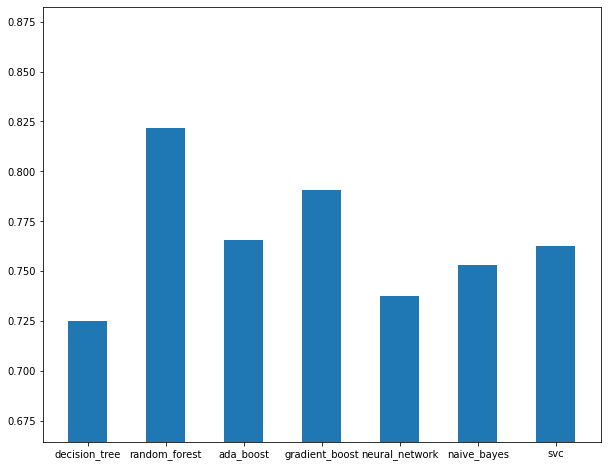

In [20]:
import matplotlib.pyplot as plt

acc_list = list(acc_dicts.values())

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.set_ylim(get_ylim(acc_list))
ax.bar(acc_dicts.keys(), acc_dicts.values(), 0.5)

As seen in above figure - random forest is clearly the best. Second place is often matter of luck as other algorithms are quite close to each other. Now let's see if using repeated stratified k-fold for validation accuracy will confirm these results.

# Evaluating same models with repeated stratified k-fold

In [21]:
kfold_scores = {key:0.0 for key in acc_dicts.keys()}

In [22]:
from sklearn.model_selection import cross_val_score,RepeatedStratifiedKFold

cv=RepeatedStratifiedKFold(n_splits=5,n_repeats=4,random_state=8)

dtc_kfold = DecisionTreeClassifier()
kfold_scores['decision_tree'] = cross_val_score(dtc_kfold, x,y,scoring='accuracy', cv=cv, n_jobs=-1)

In [23]:
rfc_kfold = RandomForestClassifier(n_jobs=-1)
kfold_scores['random_forest'] = cross_val_score(rfc_kfold, x,y,scoring='accuracy', cv=cv, n_jobs=-1)

In [24]:
abc_kfold = AdaBoostClassifier()
kfold_scores['ada_boost'] = cross_val_score(abc_kfold, x,y,scoring='accuracy', cv=cv, n_jobs=-1)

In [25]:
gbc_kfold = GradientBoostingClassifier()
kfold_scores['gradient_boost'] = cross_val_score(gbc_kfold, x,y,scoring='accuracy', cv=cv, n_jobs=-1)

In [26]:
def nn_cross_val_score(model, x, y, batch_size=16, epochs=100):
    nn_acc_scores=[]
    for train_index, test_index in cv.split(x, y):
        x_train_scaled, x_test_scaled = get_scaled_attr(x.iloc[train_index], x.iloc[test_index])
        k_fold_y_train = y[train_index] if y.nunique() <= 2 else pd.get_dummies(y[train_index])
        k_fold_y_test = y[test_index] if y.nunique() <= 2 else pd.get_dummies(y[test_index])

        model.fit(x_train_scaled, k_fold_y_train, batch_size=batch_size, epochs=epochs, verbose=0, shuffle=True, validation_split=0.15,
                           callbacks=[EarlyStopping(patience=10, monitor='val_loss', mode='min'),
                                      ModelCheckpoint('./tmp/kfold_model_checkpoint', save_best_only=True, save_weights_only=True,
                                                         monitor='val_accuracy', mode='max')])

        model.load_weights('./tmp/kfold_model_checkpoint')

        acc_score = model.evaluate(x_test_scaled, k_fold_y_test, verbose=0)[model.metrics_names.index('accuracy')]
        nn_acc_scores.append(acc_score)
    return nn_acc_scores

In [27]:
kfold_scores['neural_network'] = nn_cross_val_score(get_default_nn_model(), x, y_binary)

In [28]:
gnb_kfold = GaussianNB()
kfold_scores['naive_bayes'] = cross_val_score(gnb_kfold, x,y,scoring='accuracy', cv=cv, n_jobs=-1)

In [29]:
def svc_cross_val_score(model, x, y):
    svc_acc_scores=[]
    for train_index, test_index in cv.split(x, y):
        x_train_scaled, x_test_scaled = get_scaled_attr(x.iloc[train_index], x.iloc[test_index])

        model.fit(x_train_scaled, y[train_index])

        acc_score = accuracy_score(y[test_index], model.predict(x_test_scaled))
        svc_acc_scores.append(acc_score)
    return svc_acc_scores
    
kfold_scores['svc'] = svc_cross_val_score(SVC(), x, y)

In [30]:
def plot_two_bars(plotted_values, labels, x_ticks=list(acc_dicts.keys()), y_label='', title=''):
    x_placement = np.arange(plotted_values[0].shape[0])
    width = 0.3
    
    fig = plt.figure(figsize=(10,8))

    ax = plt.subplot(111)
    ax.set_ylim(get_ylim(np.stack([plotted_values[0], plotted_values[1]])))
    ax.bar(x_placement - 0.6 * width, plotted_values[0], width=width, color='b', align='center', label=labels[0])
    ax.bar(x_placement + 0.6 * width, plotted_values[1], width=width, color='g', align='center', label=labels[1])
    ax.bar_label(ax.containers[0], label_type='edge', fmt='%.2f')
    ax.bar_label(ax.containers[1], label_type='edge', fmt='%.2f')
    ax.set_xticks(x_placement, x_ticks)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()

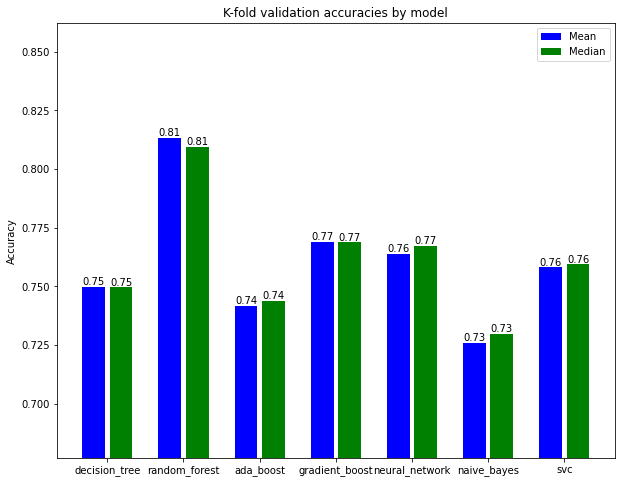

In [31]:
np_kfold = np.array(list(kfold_scores.values()))
np_kfold_mean = np.mean(np_kfold, axis=1)
np_kfold_median = np.median(np_kfold, axis=1)

plot_two_bars([np_kfold_mean, np_kfold_median], ['Mean', 'Median'], y_label='Accuracy', title='K-fold validation accuracies by model')

Here you can see that random forest is still outperforming other models. Naive bayes performs the worst. Other algorithms are still quite close to each other In next step I will check performance of those models after hyperparameters tuning

Number of leaves in default decision tree: 200


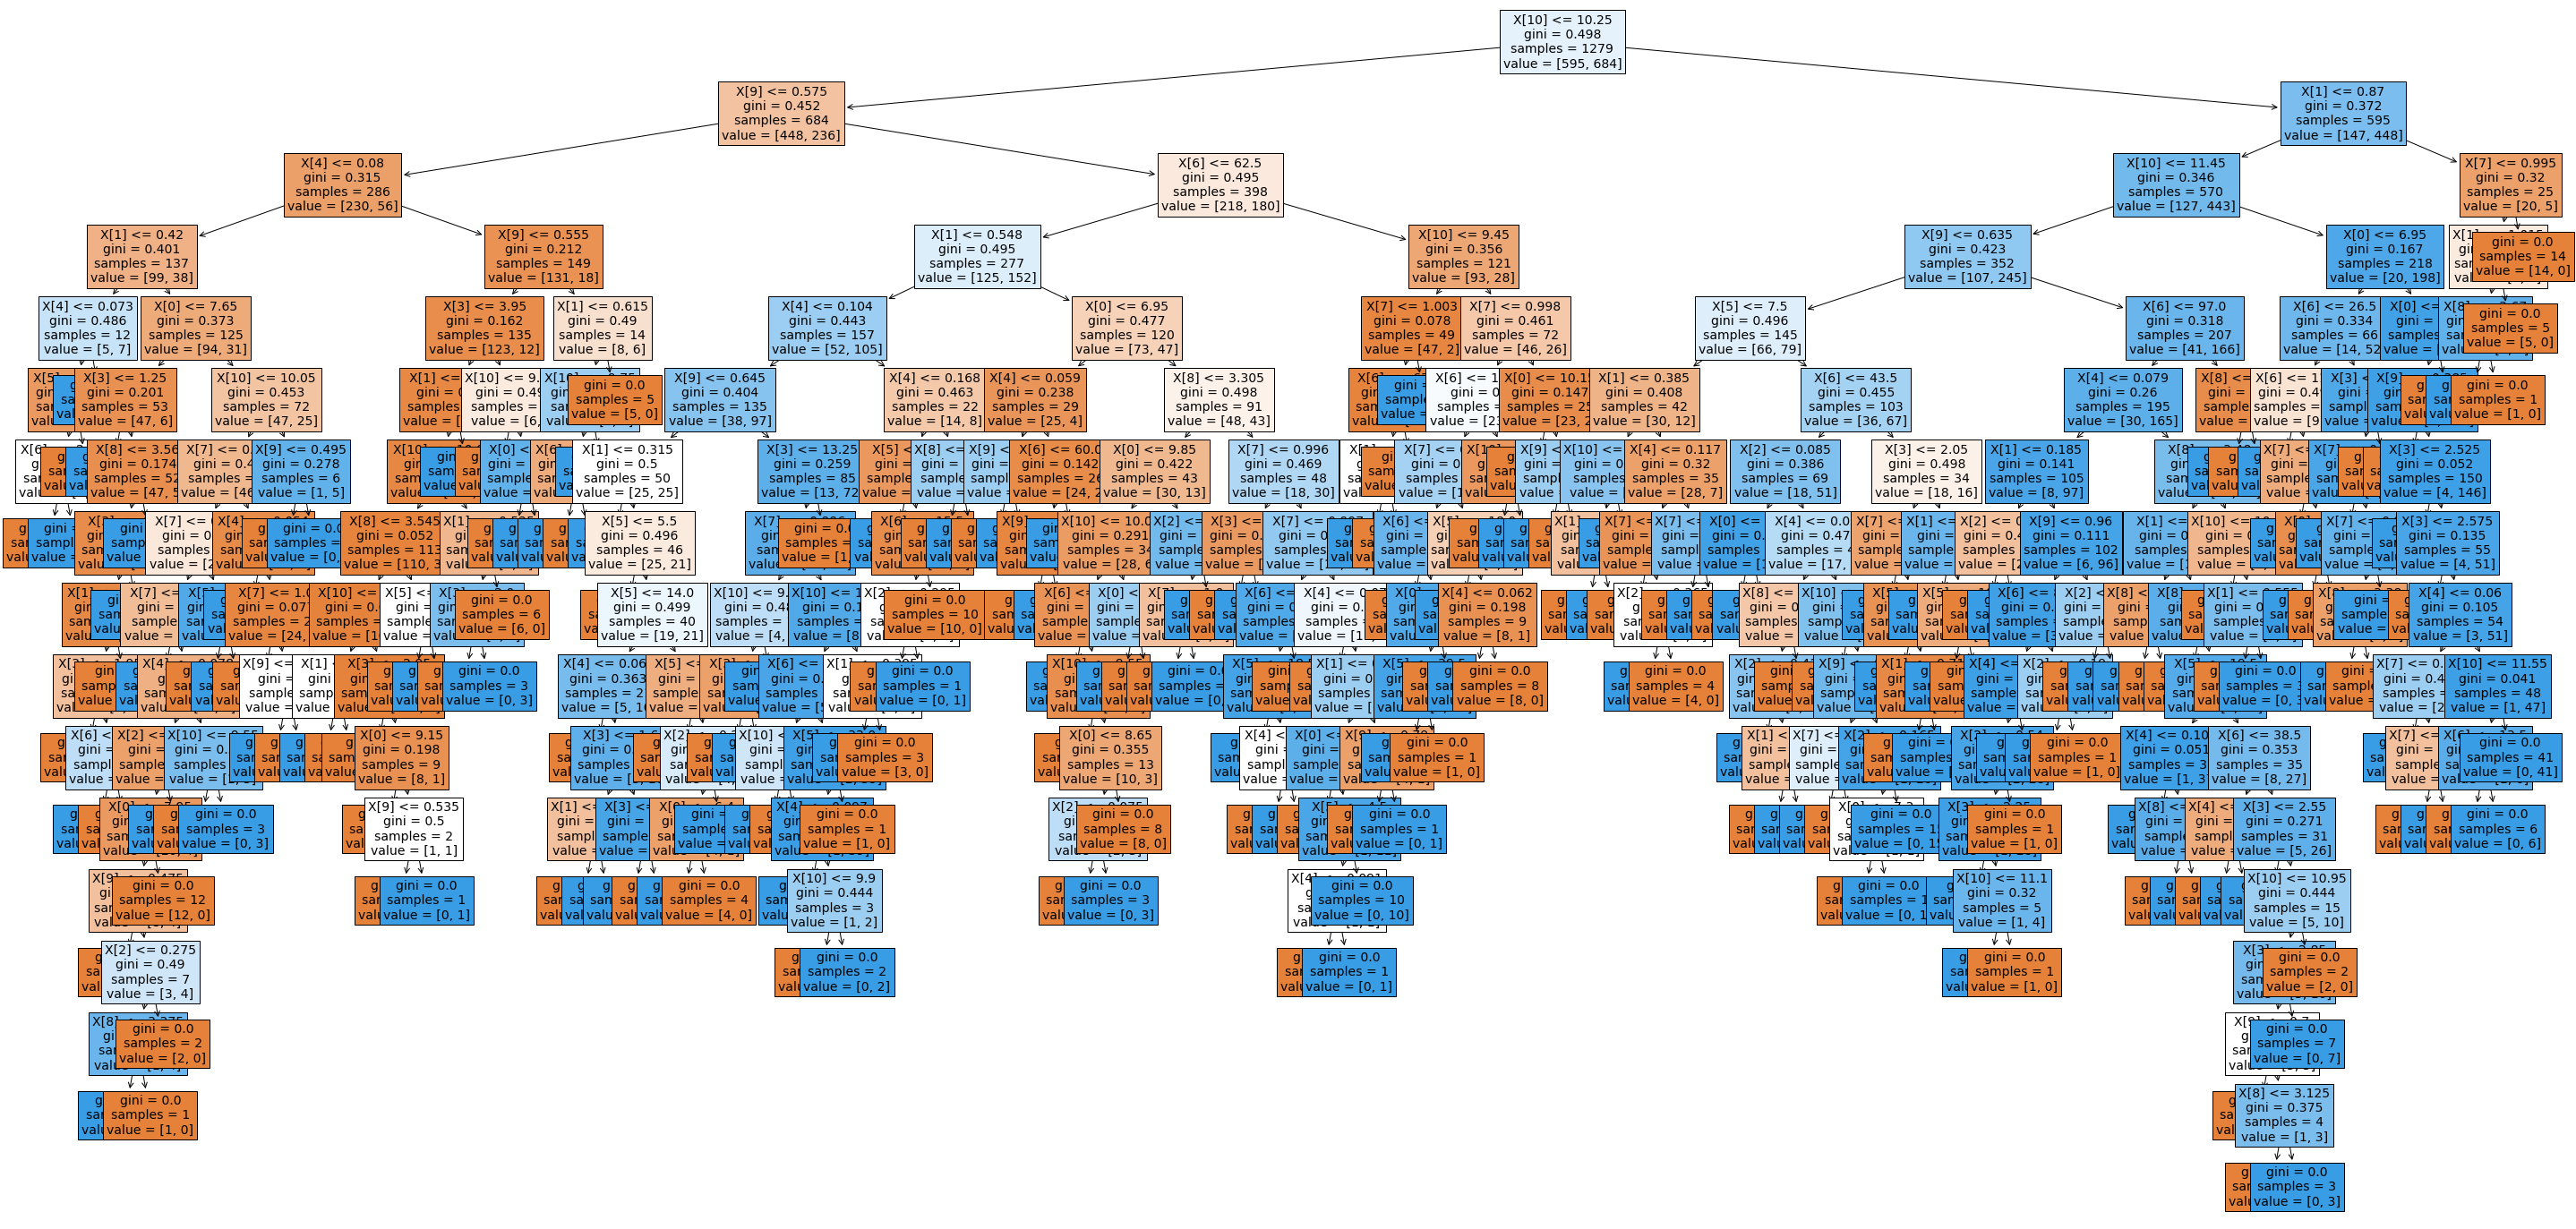

In [32]:
from sklearn.tree import plot_tree

# Let's get some intuition about size of default decision tree
print('Number of leaves in default decision tree: ' + str(dtc.get_n_leaves()))
plt.figure(figsize=(50,25))
plot_tree(dtc, filled=True, fontsize=14)
plt.show()

# Hyperparameters tuning

Hyperparameter tuning for each model will be conducted with random search and will search through 75 combinations to get best result

In [33]:
from sklearn.model_selection import RandomizedSearchCV
ht_iterations = 75
ht_scores = {key:0.0 for key in acc_dicts.keys()}

In [34]:
max_depth_arr = np.arange(3,20,3).tolist()
max_leaf_arr = np.arange(25, 400, 25).tolist()
max_depth_arr.append(None)
max_leaf_arr.append(None)
dtc_ht = DecisionTreeClassifier()
search_space = {
    'criterion': ['gini', 'entropy'],
    'max_depth': max_depth_arr,
#     those parameters turned out to give best performance when left with default values
#     'min_samples_split': np.arange(2,40),
#     'min_impurity_decrease': np.arange(0.0, 0.5, 0.075),
#     'ccp_alpha': np.arange(0.0, 0.2, 0.01),
    'max_leaf_nodes': max_leaf_arr
}
                  
ht_rs_dtc = RandomizedSearchCV(dtc_ht, search_space, scoring='accuracy', cv=cv, n_jobs=-1, n_iter=ht_iterations, verbose=1)
ht_rs_dtc.fit(x,y)
print('Best parameters have achieved the score: ' + str(ht_rs_dtc.best_score_)  + ' and they are following: \n' + str(ht_rs_dtc.best_params_))
ht_scores['decision_tree'] = ht_rs_dtc.best_score_

Fitting 20 folds for each of 75 candidates, totalling 1500 fits
Best parameters have achieved the score: 0.7582802703761756 and they are following: 
{'max_leaf_nodes': 200, 'max_depth': None, 'criterion': 'gini'}


In [35]:
rfc_ht = RandomForestClassifier(n_jobs=-1)
search_space = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': max_depth_arr,
    'max_leaf_nodes': max_leaf_arr
}
                  
ht_rs_rfc = RandomizedSearchCV(rfc_ht, search_space, scoring='accuracy', cv=cv, n_jobs=-1, n_iter=ht_iterations, verbose=1)
ht_rs_rfc.fit(x,y)
print('Best parameters have achieved the score: ' + str(ht_rs_rfc.best_score_)  + ' and they are following: \n' + str(ht_rs_rfc.best_params_))
ht_scores['random_forest'] = ht_rs_rfc.best_score_

Fitting 20 folds for each of 75 candidates, totalling 1500 fits
Best parameters have achieved the score: 0.8172271747648903 and they are following: 
{'n_estimators': 250, 'max_leaf_nodes': 375, 'max_depth': None, 'criterion': 'entropy'}


In [36]:
abc_ht = AdaBoostClassifier()
search_space = {
    'n_estimators': np.arange(25, 251, 25),
    'learning_rate': np.arange(0.1, 2.5, 0.1),
}

ht_rs_abc = RandomizedSearchCV(abc_ht, search_space, scoring='accuracy', cv=cv, n_jobs=-1, n_iter=ht_iterations, verbose=1)
ht_rs_abc.fit(x,y)
print('Best parameters have achieved the score: ' + str(ht_rs_abc.best_score_)  + ' and they are following: \n' + str(ht_rs_abc.best_params_))
ht_scores['ada_boost'] = ht_rs_abc.best_score_

Fitting 20 folds for each of 75 candidates, totalling 1500 fits
Best parameters have achieved the score: 0.7546884796238243 and they are following: 
{'n_estimators': 150, 'learning_rate': 0.30000000000000004}


In [37]:
gbc_ht = GradientBoostingClassifier()
search_space = {
    'n_estimators': np.arange(25, 251, 25),
    'learning_rate': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
    'subsample': np.arange(0.1, 1.1, 0.1),
    'max_depth': np.arange(1,5)
}

ht_rs_gbc = RandomizedSearchCV(gbc_ht, search_space, scoring='accuracy', cv=cv, n_jobs=-1, n_iter=ht_iterations, verbose=1)
ht_rs_gbc.fit(x,y)
print('Best parameters have achieved the score: ' + str(ht_rs_gbc.best_score_)  + ' and they are following: \n' + str(ht_rs_gbc.best_params_))
ht_scores['gradient_boost'] = ht_rs_gbc.best_score_

Fitting 20 folds for each of 75 candidates, totalling 1500 fits
Best parameters have achieved the score: 0.7934668887147336 and they are following: 
{'subsample': 0.6, 'n_estimators': 250, 'max_depth': 4, 'learning_rate': 0.3}


In [38]:
import keras_tuner as kt

# creating custom keras tuner for searching hyperparameters in same manner as in previous algorithms (using k-fold cross-validation)
# by doing this I can also tune batch size
class CVTuner(kt.RandomSearch):
  def run_trial(self, trial, x, y, *args, **kwargs):
    passed_cv = kwargs['cv']
    batch_size = trial.hyperparameters.Choice('batch_size', [8, 16, 32])
    epochs = 100
    val_accs = []
    for train_indices, test_indices in passed_cv.split(x, y):
      x_train, x_test = x.iloc[train_indices], x.iloc[test_indices]
      y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
      x_train_scaled, x_test_scaled = get_scaled_attr(x_train, x_test)
      model = self.hypermodel.build(trial.hyperparameters)
        
      model.fit(x_train_scaled, y_train, batch_size=batch_size, epochs=epochs, verbose=0, shuffle=True, validation_split=0.15,
                                   callbacks=[EarlyStopping(patience=10, monitor='val_loss', mode='min'),
                                              ModelCheckpoint('./tmp/ht_model_checkpoint', save_best_only=True, save_weights_only=True,
                                                                 monitor='val_accuracy', mode='max')])
      model.load_weights('./tmp/ht_model_checkpoint')
      val_accs.append(model.evaluate(x_test_scaled, y_test, verbose=0)[model.metrics_names.index('accuracy')])
    self.oracle.update_trial(trial.trial_id, {'val_acc': np.mean(val_accs)})

In [39]:
from tensorflow.python.keras.regularizers import l2

def build_model_for_hp_tune(hp, num_of_target_classes=1):
    layers_quantity = hp.Int('layers_quantity', 1, 2)
    learning_rate = hp.Float('learning_rate', 1e-6, 1e-2, sampling='log')
    regularize_factor = hp.Choice('regularization_factor', [0.0, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 1e-2])

    inputs = tf.keras.Input(shape=(len(x_train.columns),))
    for i in range(layers_quantity):
        num_of_neurons = hp.Choice(f'number_of_neurons_{i}_layer', [4, 8, 16], parent_name='layers_quantity', parent_values=list(range(i + 1, layers_quantity + 1)))
        if i == 0:
            hidden = tf.keras.layers.Dense(num_of_neurons, activation='relu', kernel_initializer = tf.keras.initializers.HeNormal(),
                                           kernel_regularizer=l2(regularize_factor),
                                           bias_regularizer=l2(regularize_factor))(inputs)
        else:
            hidden = tf.keras.layers.Dense(num_of_neurons, activation='relu', kernel_initializer = tf.keras.initializers.HeNormal(),
                                               kernel_regularizer=l2(regularize_factor),
                                               bias_regularizer=l2(regularize_factor))(hidden)
    if num_of_target_classes == 1:
        outputs = tf.keras.layers.Dense(1, activation='sigmoid')(hidden)
        loss_function = 'binary_crossentropy'
    else:
        outputs = tf.keras.layers.Dense(num_of_target_classes, activation='softmax')(hidden)
        loss_function = 'categorical_crossentropy'
    model = tf.keras.Model(inputs=inputs, outputs = outputs)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss=loss_function, metrics=['accuracy'])
    return model

In [40]:
tuner = CVTuner(build_model_for_hp_tune,
                objective='val_acc',
                max_trials=ht_iterations,
                executions_per_trial=1,
                overwrite=False,
                directory="./",
                project_name="wine_quality")

tuner.search(x, y_binary, cv=cv)
best_nn_trial = tuner.oracle.get_best_trials(1)[0]
print('Best parameters have achieved the score: ' + str(best_nn_trial.score)  + ' and they are following: \n' + str(best_nn_trial.hyperparameters.values))
ht_scores['neural_network'] = best_nn_trial.score

Trial 75 Complete [00h 03m 07s]
val_acc: 0.5198589384555816

Best val_acc So Far: 0.7493774503469467
Total elapsed time: 05h 03m 18s
Best parameters have achieved the score: 0.7493774503469467 and they are following: 
{'layers_quantity': 1, 'learning_rate': 0.004554542502081448, 'regularization_factor': 0.0003, 'number_of_neurons_0_layer': 16, 'batch_size': 16}


In [41]:
gnb_ht = GaussianNB()
search_space = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

ht_rs_gnb = RandomizedSearchCV(gnb_ht, search_space, scoring='accuracy', cv=cv, n_jobs=-1, n_iter=ht_iterations, verbose=1)
ht_rs_gnb.fit(x,y)
print('Best parameters have achieved the score: ' + str(ht_rs_gnb.best_score_)  + ' and they are following: \n' + str(ht_rs_gnb.best_params_))
ht_scores['naive_bayes'] = ht_rs_gnb.best_score_

Fitting 20 folds for each of 75 candidates, totalling 1500 fits
Best parameters have achieved the score: 0.7266991575235109 and they are following: 
{'var_smoothing': 6.579332246575682e-09}


In [42]:
from sklearn.pipeline import make_pipeline

gamma_list = np.logspace(-4, 1, num=25).tolist()
gamma_list.extend(['scale', 'auto'])

search_space = {
    'svc__C': [0.1, 0.3, 1, 3, 10, 30, 100],
    'svc__gamma': gamma_list
}

svc_pipeline = make_pipeline(RobustScaler(), 
                    SVC())

ht_rs_svc = RandomizedSearchCV(svc_pipeline, search_space, scoring='accuracy', cv=cv, n_jobs=-1, n_iter=ht_iterations, verbose=1)
ht_rs_svc.fit(x,y)
print('Best parameters have achieved the score: ' + str(ht_rs_svc.best_score_)  + ' and they are following: \n' + str(ht_rs_svc.best_params_))
ht_scores['svc'] = ht_rs_svc.best_score_

Fitting 20 folds for each of 75 candidates, totalling 1500 fits
Best parameters have achieved the score: 0.77048638322884 and they are following: 
{'svc__gamma': 0.9085175756516871, 'svc__C': 3}


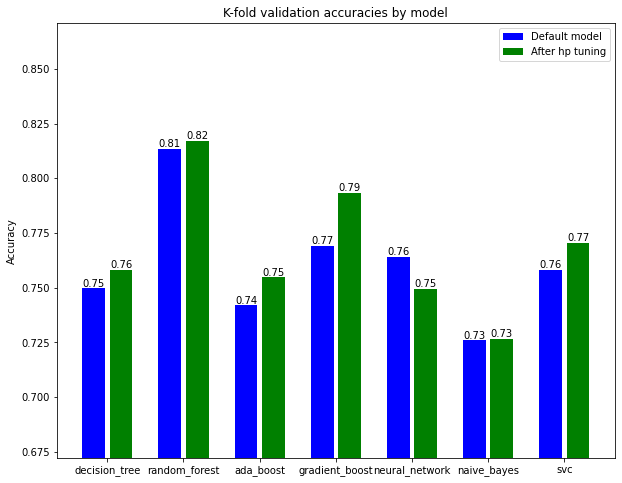

In [43]:
ht_mean = np.array(list(ht_scores.values()))

plot_two_bars([np_kfold_mean, ht_mean], ['Default model', 'After hp tuning'], y_label='Accuracy', title='K-fold validation accuracies by model')

Most of the models got at least some improvement in accuracy after hyperparameters tuning. Gradient boosting is most noticeable here. But nevertheless random forest is still the best.

# Evaluating models on reviews without grouping

Now let's once again test accuracies for given models but without grouping reviews into "*Bad*" and "*Good*". I hope parameters tuned for grouped target classes will be closer to optimum than default ones

In [44]:
y_wo_group = wine_attr['quality']

kfold_scores_wo_group = {key:0.0 for key in acc_dicts.keys()}

In [45]:
dtc_wo_group = DecisionTreeClassifier(**ht_rs_dtc.best_params_)
kfold_scores_wo_group['decision_tree'] = cross_val_score(dtc_wo_group, x,y_wo_group, scoring='accuracy', cv=cv, n_jobs=-1)

rfc_kfold_wo_group = RandomForestClassifier(n_jobs=-1,**ht_rs_rfc.best_params_)
kfold_scores_wo_group['random_forest'] = cross_val_score(rfc_kfold_wo_group, x,y_wo_group,scoring='accuracy', cv=cv, n_jobs=-1)

abc_kfold_wo_group = AdaBoostClassifier(**ht_rs_abc.best_params_)
kfold_scores_wo_group['ada_boost'] = cross_val_score(abc_kfold_wo_group, x,y_wo_group,scoring='accuracy', cv=cv, n_jobs=-1)

gbc_kfold_wo_group = GradientBoostingClassifier(**ht_rs_gbc.best_params_)
kfold_scores_wo_group['gradient_boost'] = cross_val_score(gbc_kfold_wo_group, x,y_wo_group,scoring='accuracy', cv=cv, n_jobs=-1)

gnb_kfold_wo_group = GaussianNB(**ht_rs_gnb.best_params_)
kfold_scores_wo_group['naive_bayes'] = cross_val_score(gnb_kfold_wo_group, x,y_wo_group,scoring='accuracy', cv=cv, n_jobs=-1)

svc_kfold_wo_group = SVC(C=ht_rs_svc.best_params_['svc__C'], gamma=ht_rs_svc.best_params_['svc__gamma'])
kfold_scores_wo_group['svc'] = svc_cross_val_score(svc_kfold_wo_group, x, y_wo_group)

In [46]:
best_hps = tuner.get_best_hyperparameters(1)[0]
hp_opt_nn_model = build_model_for_hp_tune(best_hps, y_wo_group.nunique())
kfold_scores_wo_group['neural_network'] = nn_cross_val_score(hp_opt_nn_model, x, y_wo_group, batch_size=best_hps['batch_size'])

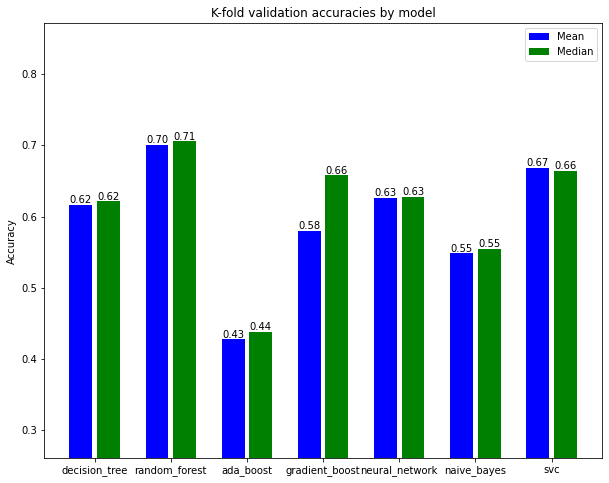

In [47]:
np_kfold_wo_group = np.array(list(kfold_scores_wo_group.values()))
np_kfold_mean_wo_group = np.mean(np_kfold_wo_group, axis=1)
np_kfold_median_wo_group = np.median(np_kfold_wo_group, axis=1)

plot_two_bars([np_kfold_mean_wo_group, np_kfold_median_wo_group], ['Mean', 'Median'], y_label='Accuracy', title='K-fold validation accuracies by model')

Random forest wins once again but this time it outrun gradient boosting machines very subtly. Let's search for best hyperparameters for the last time

In [48]:
rfc_ht_wog = RandomForestClassifier(n_jobs=-1)
search_space = {
    'criterion': ['gini', 'entropy'],
    'n_estimators': np.arange(50, 500, 50),
    'max_depth': max_depth_arr,
    'max_leaf_nodes': max_leaf_arr
}
                  
ht_rs_rfc_wog = RandomizedSearchCV(rfc_ht_wog, search_space, scoring='accuracy', cv=cv, n_jobs=-1, n_iter=ht_iterations*2, verbose=1)
ht_rs_rfc_wog.fit(x,y_wo_group)
print('Best parameters have achieved the score: ' + str(ht_rs_rfc_wog.best_score_)  + ' and they are following: \n' + str(ht_rs_rfc_wog.best_params_))

Fitting 20 folds for each of 150 candidates, totalling 3000 fits
Best parameters have achieved the score: 0.7038753918495299 and they are following: 
{'n_estimators': 450, 'max_leaf_nodes': 325, 'max_depth': None, 'criterion': 'gini'}


Checking final models for both approches (grouped/ungrouped target class) using train/test set from the beginning.

Classification report: 
              precision    recall  f1-score   support

         Bad       0.82      0.85      0.83       149
        Good       0.86      0.84      0.85       171

    accuracy                           0.84       320
   macro avg       0.84      0.84      0.84       320
weighted avg       0.84      0.84      0.84       320

Confusion matrix: 



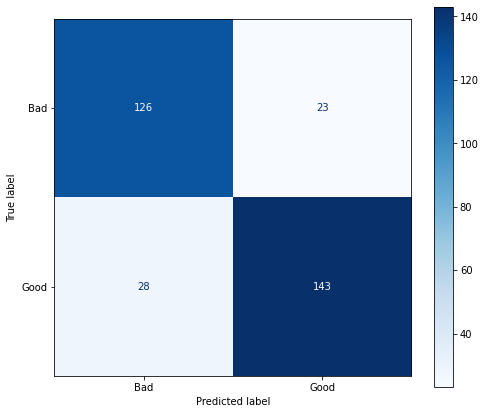

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, multilabel_confusion_matrix

rfc_test_w_groups = RandomForestClassifier(n_jobs=-1, **ht_rs_rfc.best_params_)
rfc_test_w_groups.fit(x_train, y_train)
y_pred_w_groups = rfc_test_w_groups.predict(x_test)
print('Classification report: \n' + classification_report(y_test, y_pred_w_groups))
print('Confusion matrix: \n')

fig, ax = plt.subplots(figsize=(8,7))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_w_groups, display_labels=rfc_test_w_groups.classes_, ax=ax, cmap='Blues')

In [50]:
y_wo_group_train = y_wo_group.loc[y_train.index]
y_wo_group_test = y_wo_group.loc[y_test.index]

Classification report: 
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         7
           5       0.76      0.84      0.80       140
           6       0.66      0.69      0.68       129
           7       0.59      0.47      0.53        40
           8       0.00      0.00      0.00         2

    accuracy                           0.70       320
   macro avg       0.34      0.33      0.33       320
weighted avg       0.67      0.70      0.69       320

Confusion matrix: 



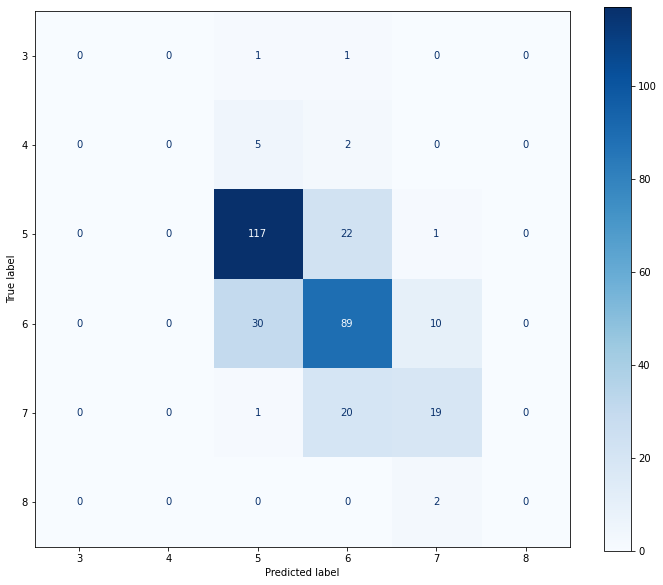

In [51]:
rfc_test_wo_groups = RandomForestClassifier(n_jobs=-1, **ht_rs_rfc_wog.best_params_)
rfc_test_wo_groups.fit(x_train, y_wo_group_train)
y_pred_wo_groups = rfc_test_wo_groups.predict(x_test)
print('Classification report: \n' + classification_report(y_wo_group_test, y_pred_wo_groups))
print('Confusion matrix: \n')

fig, ax = plt.subplots(figsize=(12,10))
disp = ConfusionMatrixDisplay.from_predictions(y_wo_group_test, y_pred_wo_groups, ax=ax, cmap='Blues')

# Thank you for you attention!